In [84]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import string
import torch.nn as nn
import pickle
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
ImageTransforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Encoder part
class Encoder_part(nn.Module):
    def __init__(self):
        super(Encoder_part, self).__init__()
        
        self.k    = 8    # number of clusters
        self.beta = 1  # wk = 2*beta*ck
        self.D    = 512   # D in W x H x D
        self.normalize_input = True
        
        self.conv11 = nn.Conv2d(self.D, self.k, kernel_size=(1,1))
        self.cluster_centres = nn.Parameter(torch.rand([self.k, self.D]))
    
        self.init_params()
        
    def init_params(self):
        self.conv11.weight = nn.Parameter(
            (2.0*self.beta*self.cluster_centres.unsqueeze(-1).unsqueeze(-1))
        )
        self.conv11.bias = nn.Parameter(
            -self.beta*self.cluster_centres.norm(dim = 1)#**2
        )
        
    def forward(self, x):
            
        n, d = x.shape[:2]
        
        # soft-assign weights, a_ij
        a = self.conv11(x).view(n, self.k, -1) # n x k x m
        a = F.softmax(a, dim = 1)
        
        x_flatten = x.view(n, d, -1)
        
        # residuals to each cluster
        # vlad = torch.zeros([n, self.k, d], dtype = x.dtype)
        
        residuals = x_flatten.expand(self.k, -1, -1, -1).permute(1,0,2,3) - self.cluster_centres.expand(n, x_flatten.shape[-1],-1,-1).permute(0,2,3,1)
        residuals *= a.unsqueeze(2)
        vlad = residuals.sum(dim = -1)
        
        vlad = F.normalize(vlad, p = 2, dim=2) # intra-normalization
        vlad = vlad.view(n, -1) # flatten
        vlad = F.normalize(vlad, p = 2, dim = 1)
        
        # vlad = self.layers(vlad)
        
        return vlad

enc = Encoder_part()
def Extract_features(imagesFolder,encoder_model = enc, path = None):
    if path is None:
        
        # vgg model
        vgg = models.vgg16(pretrained=True)
        
        Features = {}
        for name in tqdm(os.listdir(imagesFolder)):
            image = Image.open(imagesFolder+"/"+name)
            image = ImageTransforms(image)
            image = image.unsqueeze(0)
            # netvlad on Extracted features of VGG
            Features[name] = enc(vgg.features(image))
            
        return Features
    else:
        
        with open(path, "rb") as f:
            Features = pickle.load(f)
            
        return Features
    
def MapAllCaptions(captionsFile):
    
    CaptionMap = {}
    captions = None
    with open(captionsFile, 'r') as f:
        captions = f.read().split("\n")
    removePunct = str.maketrans("", "", string.punctuation)
    for caption in captions:
        Id, cap = caption.split("#")[0],caption.split()[1:]
        cap = [word.lower() for word in cap]
        cap = [word.translate(removePunct) for word in cap]
        cap = [word for word in cap if (len(word)>1 and word.isalpha())]
        cap = "<start> "+ " ".join(cap)+" "+"<end>"
        
        try :
            CaptionMap[Id].append(cap)
        except:
            CaptionMap[Id] = [cap]
            
    return CaptionMap

In [5]:
# vgg-netvlad features
features = Extract_features("./Images",enc, "./image_features.pkl")
with open("./vgg_netvlad_features.pkl", "wb") as f:
    pickle.dump(features, f)

In [55]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        # define the properties
        self.fc1 = torch.nn.Linear(4096, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)
        
        # lstm 
        self.lstm = torch.nn.LSTM(self.embed_size, self.hidden_size, batch_first=True)    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        
        self.embed.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        # activations
        
    
    def forward(self, caption, features):
        x = self.dropout1(features)
        x = self.fc1(x)
        x = F.relu(x)
        
        x1 = self.embed(caption)
        x1 = self.dropout2(x1)
        x1,_ = self.lstm(x1)
        x1 = x1[:, -1, :] # taking the prediction of last word only
        
        x2 = F.relu(self.fc2(x+x1))
        outputs = self.fc_out(x2)
        outputs = F.log_softmax(outputs, dim=-1)
        return outputs


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.fc1 = torch.nn.Linear(4096, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)
        
        # lstm 
        self.lstm = torch.nn.LSTM(self.embed_size, self.hidden_size, batch_first=True)    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        
        self.embed.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        # activations
        
    
    def forward(self, caption, features):
        x = self.dropout1(features)
        x = self.fc1(x)
        x = F.relu(x)
        
        x1 = self.embed(caption)
        x1 = self.dropout2(x1)
        x1,_ = self.lstm(x1)
        x1 = x1[:, -1, :] # taking the prediction of last word only
        
        x2 = F.relu(self.fc2(x+x1))
        outputs = self.fc_out(x2)
        outputs = F.log_softmax(outputs, dim=-1)
        return outputs


In [52]:
def Data_generator(captions, encoder_features, batch_size, tokenizer=tokenizer):
    enc_op, input_dec , out = [], [], []
    count = 0
    
    while True:
        for key, ref_caps in captions.items():
            image = encoder_features[key][0]
            
            for cap in ref_caps:
                seq = tokenizer.texts_to_sequences([cap])[0]
                
                for i in range(1,len(seq)):
                    in_cap, out_word = seq[:i], seq[i]
                    in_cap = pad_sequences([in_cap], maxlen=max_length)[0]
                    
                    enc_op.append(image)
                    input_dec.append(in_cap)
                    out.append(out_word)
                    count +=1
                    
                    if count==batch_size:
                        yield(
                            torch.FloatTensor(enc_op),
                            torch.LongTensor(input_dec),
                            torch.LongTensor(out)
                        )
                        enc_op, input_dec , out = [], [], []
                        count = 0

In [38]:
hidden_size = 256
embed_Dim = 200
ImageCaptionMap = MapAllCaptions("./5/captions.txt")

Images = list(features.keys())
split = int(0.8*len(Images))
train_images, test_images = Images[:split],Images[split:]

In [39]:
train_X = {}
train_Y = {}
test_X = {}
test_Y = {}

for im in train_images:
    train_X[im] = features[im]
    train_Y[im] = ImageCaptionMap[im]
    
for im in test_images:
    test_X[im] = features[im]
    test_Y[im] = ImageCaptionMap[im]

In [40]:
All_captions = []
for caps in ImageCaptionMap.values():
    for cap in caps:
        All_captions.append(cap)

max_length = max([len(cap.split()) for cap in All_captions])
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(All_captions)
vocab_size = len(tokenizer.word_index)+1

In [41]:
ImageCaptionMap

{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<star

In [44]:
# glove vectors
Glove = {}
glove_path = './glove.6B/glove.6B.200d.txt'
G = []
with open(glove_path, 'rb') as f:
    for line in f:
        temp = line.decode().split()
        Glove[temp[0]] = list(map(float, temp[1:]))

In [47]:
# Embedding matrix
word_to_idx = tokenizer.word_index
matrix_len = len(word_to_idx)+1
emb_dim = 200
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0
un_found_words = []
for word,idx in word_to_idx.items():
    try: 
        weights_matrix[idx] = Glove[word]
        words_found += 1
    except KeyError:
        print(word)
        un_found_words.append(word)
        weights_matrix[idx] = np.random.randn(emb_dim)

tshirt
snowcovered
rollerblader
merrygoround
waterskier
floaties
upsidedown
wakeboarder
tugofwar
bicycler
darkhaired
africanamerican
darkskinned
dalmation
offcamera
tshirts
wakeboards
brownhaired
somthing
hulahoops
parasails
outstreached
fourwheeler
treelined
fencedin
midjump
blackandwhite
surfboarder
lightcolored
inground
hiviz
threewheeled
corndogs
plushie
windsurfs
redhaired
carying
brightlycolored
longnecked
waterskies
facepaint
middleaged
stripy
hulahoop
waterskis
parasailer
grayhaired
ollies
tugowar
retreiver
graffiticovered
onehanded
fingerpaints
gocart
rockclimbing
drapped
intertube
tball
thumbsup
blondehaired
blondhaired
restaraunt
rollerskater
sveral
backgroud
welllit
backtoback
frolicks
rappels
lightup
dirtbikes
flipflops
highfive
welldressed
oldfashioned
starshaped
highfives
mosscovered
dirtcovered
leafcovered
cloudcovered
curlyhaired
ralley
whiel
kisscostumed
surfboarding
artsstyle
barbwire
parasailors
darkcolored
mountian
offroading
hods
longhandled
grayhound
coldweather


In [75]:
word_to_idx

{'end': 1,
 'start': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'down': 35,
 'shirt': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'child': 41,
 'person': 42,
 'snow': 43,
 'jumping': 44,
 'over': 45,
 'front': 46,
 'three': 47,
 'sitting': 48,
 'holding': 49,
 'field': 50,
 'small': 51,
 'up': 52,
 'by': 53,
 'large': 54,
 'green': 55,
 'one': 56,
 'group': 57,
 'yellow': 58,
 'her': 59,
 'walking': 60,
 'children': 61,
 'men': 62,
 'into': 63,
 'air': 64,
 'beach': 65,
 'near': 66,
 'mouth': 67,
 'jumps': 68,
 'another': 69,
 'for': 70,
 'street': 71,
 'runs': 72,
 'its': 73,
 'from': 74,
 'riding': 75,


In [58]:
# parameters
epochs = 10
batch_size = 16

steps = len(train_Y) // batch_size

In [56]:
decoder_model = Decoder(embed_Dim,hidden_size, vocab_size, weights_matrix)

In [77]:
optimizer = optim.Adam(decoder_model.parameters(), lr = 0.0003)
training_loss = []

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}"+"\n"+"*"*50)
    data_generator = Data_generator(train_Y,train_X, batch_size )
    loss_epoch = 0
    
    for batch in range(steps):
        
        enc_op, dec_ip, cap_out = next(data_generator)
        optimizer.zero_grad()
        preds = decoder_model( dec_ip, enc_op)
        loss = F.nll_loss(preds, cap_out)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.data.item()
        
        if batch % 100 ==0:
            print("Epoch {} - Batch {} - Loss {:.4f}".format(
                epoch+1, batch, loss
            ))
            
    print("Epoch {} - Average loss {:.4f}".format(
        epoch+1, loss_epoch/steps
    ))
    
    training_loss.append(loss_epoch/steps)
    
    # Save model
    torch.save(decoder_model.state_dict(),  "./models/model_q2rec_{}".format(epoch+11))

    print("\n==============================================\n")

            

Epoch 1
**************************************************
Epoch 1 - Batch 0 - Loss 2.2168
Epoch 1 - Batch 100 - Loss 2.0955
Epoch 1 - Batch 200 - Loss 4.0153
Epoch 1 - Batch 300 - Loss 2.3889
Epoch 1 - Batch 400 - Loss 2.5111
Epoch 1 - Average loss 2.2740


Epoch 2
**************************************************
Epoch 2 - Batch 0 - Loss 2.5133
Epoch 2 - Batch 100 - Loss 1.8025
Epoch 2 - Batch 200 - Loss 3.5296
Epoch 2 - Batch 300 - Loss 2.0075
Epoch 2 - Batch 400 - Loss 2.1285
Epoch 2 - Average loss 1.9750


Epoch 3
**************************************************
Epoch 3 - Batch 0 - Loss 1.8530
Epoch 3 - Batch 100 - Loss 1.4744
Epoch 3 - Batch 200 - Loss 3.0007
Epoch 3 - Batch 300 - Loss 2.0090
Epoch 3 - Batch 400 - Loss 1.8876
Epoch 3 - Average loss 1.8655


Epoch 4
**************************************************
Epoch 4 - Batch 0 - Loss 1.9346
Epoch 4 - Batch 100 - Loss 1.2922
Epoch 4 - Batch 200 - Loss 3.1066
Epoch 4 - Batch 300 - Loss 1.9142
Epoch 4 - Batch 400 - Loss 1.8

In [70]:
import matplotlib.pyplot as plt

In [71]:
idx_to_word = {}
for k,v in tokenizer.word_index.items():
    idx_to_word[v] = k

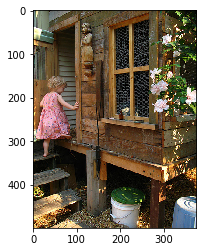

predicted:  [2, 39, 18, 3, 89, 168, 6, 63, 192, 2420, 1]
start little girl in pink dress is into wooden playhouse end


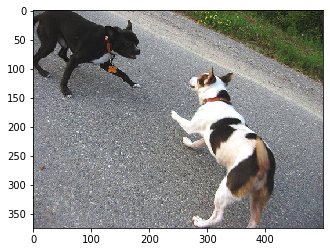

predicted:  [2, 12, 30, 5, 136, 81, 793, 136, 81, 5, 4, 153, 1]
start two dogs on each other moving each other on the road end


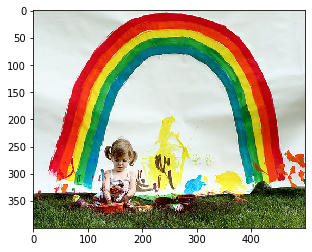

predicted:  [2, 25, 18, 9, 1554, 48, 3, 46, 11, 3423, 763, 9, 3423, 217, 9, 3423, 217, 1]
start young girl with pigtails sitting in front of fingerpaints painting with fingerpaints hands with fingerpaints hands end


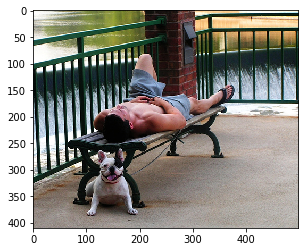

In [81]:
ex = 0
for key, captions_list in train_Y.items():
    img = plt.imread('./Images/'+key)
    plt.imshow(img)
    plt.show()    
    
    if (ex == 3):
        break
    image = train_X[key][0] # image features
    for cap in captions_list:
        seq = tokenizer.texts_to_sequences([cap])[0]
#         print("Actual: ",seq)
        
    
    in_1 = []
    in_2 = []
    in_seq = [2]
    in_seq_v = pad_sequences([in_seq], maxlen=max_length)[0]
    in_1.append(image)
    in_2.append(in_seq_v)
    in_t1 = torch.FloatTensor(in_1)
    in_t2 = torch.LongTensor(in_2)
    for i in range(max_length):
        out = decoder_model(in_t2, in_t1)
        val = torch.argmax(out)
        in_seq.append(val.item())
        in_seq_v = pad_sequences([in_seq], maxlen=max_length)[0]
        in_t2 = torch.LongTensor([in_seq_v])
        if val.item()==1:
            break
    print("predicted: ",in_seq)
    caption = [idx_to_word[i] for i in in_seq]
    print(' '.join(caption))
    ex += 1
    

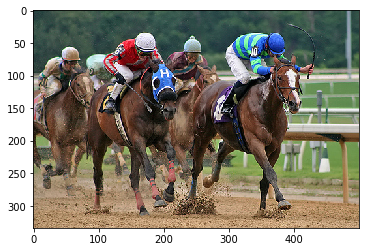

predicted:  [2, 12, 22, 16, 35, 53, 389, 1]
start two people are down by fire end


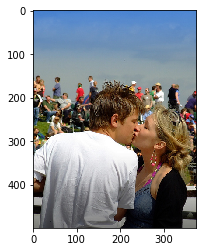

predicted:  [2, 4, 25, 15, 6, 44, 5, 4, 92, 1]
start the young boy is jumping on the camera end


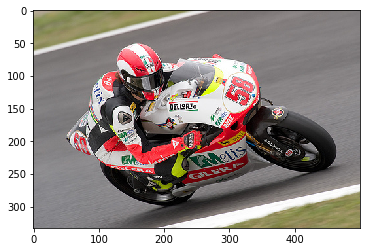

predicted:  [2, 25, 15, 6, 44, 5, 4, 153, 1]
start young boy is jumping on the road end


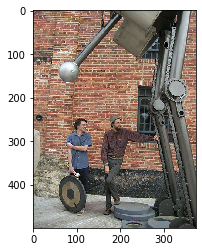

In [83]:
ex = 0
for key, captions_list in test_Y.items():
    img = plt.imread('./Images/'+key)
    plt.imshow(img)
    plt.show()    
    
    if (ex == 3):
        break
    image = test_X[key][0] # image features
    for cap in captions_list:
        seq = tokenizer.texts_to_sequences([cap])[0]
#         print("Actual: ",seq)
        
    
    in_1 = []
    in_2 = []
    in_seq = [2]
    in_seq_v = pad_sequences([in_seq], maxlen=max_length)[0]
    in_1.append(image)
    in_2.append(in_seq_v)
    in_t1 = torch.FloatTensor(in_1)
    in_t2 = torch.LongTensor(in_2)
    for i in range(max_length):
        out = decoder_model(in_t2, in_t1)
        val = torch.argmax(out)
        in_seq.append(val.item())
        in_seq_v = pad_sequences([in_seq], maxlen=max_length)[0]
        in_t2 = torch.LongTensor([in_seq_v])
        if val.item()==1:
            break
    print("predicted: ",in_seq)
    caption = [idx_to_word[i] for i in in_seq]
    print(' '.join(caption))
    ex += 1
    

In [39]:
image = Image.open('./Images/1000268201_693b08cb0e.jpg')
image = ImageTransforms(image)
image = image.unsqueeze(0)

In [47]:
enc = Encoder_part()

In [38]:
vgg = models.vgg16(pretrained=True)

In [48]:
enc(vgg.features(image)).shape

torch.Size([1, 16384])

In [50]:
enc(Features['1000268201_693b08cb0e.jpg']).shape

torch.Size([1, 16384])